# Step #1 Load the Data

In [43]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Tools for predictive data analysis. We will use the MinMaxScaler to normalize the price data 
from sklearn.preprocessing import MinMaxScaler 
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense

# Setting the timeframe for the data extraction
date_today = date.today().strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Taking a look at the shape of the dataset
print(df.shape)
df.head(5)

(2885, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980


# Step #2 Explore the Data

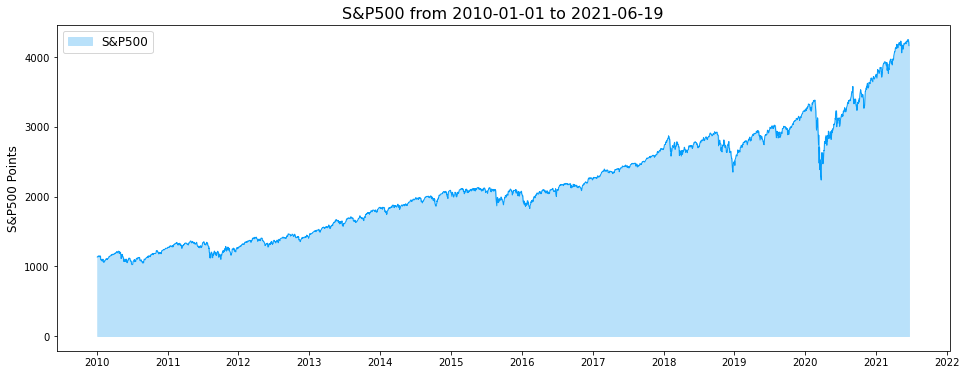

In [44]:
# Plotting the data
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df.index
y = df['Close']
ax1.fill_between(x, 0, y, color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ date_start + ' to ' + date_today, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('S&P500 Points', fontsize=12)
plt.show()

# Step #3 Preprocess the Data

In [45]:
# Feature Selection - Only Close Data
data = df.filter(['Close'])
data_unscaled = data.values

# Get the number of rows to train the model on 80% of the data 
training_data_length = math.ceil(len(data_unscaled) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(npdataset)

In [46]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

(2258, 50, 1) (2258,)
(577, 50, 1) (577,)
0.5340487524882027
0.5340487524882027


# Step #4 Model Training

In [47]:
# Configure the neural network model
model = Sequential()

# Model with 100 Neurons 
# inputshape = 100 Timestamps
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
# Training the model
model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
142/142 [==============================] - 10s 73ms/step - loss: 0.0066
Epoch 2/25
142/142 [==============================] - 10s 72ms/step - loss: 2.1347e-04 0s - loss: 2.147
Epoch 3/25
142/142 [==============================] - 10s 73ms/step - loss: 1.9044e-04
Epoch 4/25
142/142 [==============================] - 11s 74ms/step - loss: 1.8570e-04
Epoch 5/25
142/142 [==============================] - 10s 67ms/step - loss: 1.9642e-04
Epoch 6/25
142/142 [==============================] - 9s 65ms/step - loss: 1.9018e-04
Epoch 7/25
142/142 [==============================] - 9s 64ms/step - loss: 1.5529e-04
Epoch 8/25
142/142 [==============================] - 9s 64ms/step - loss: 1.5660e-04
Epoch 9/25
142/142 [==============================] - 8s 57ms/step - loss: 1.6378e-04
Epoch 10/25
142/142 [==============================] - 8s 53ms/step - loss: 1.7796e-04
Epoch 11/25
142/142 [==============================] - 7s 53ms/step - loss: 1.3134e-04
Epoch 12/25
142/142 [=============

In [49]:
# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

# Step #5 Evaluate model performance

In [50]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('MAE: ' + str(round(mae, 1)))

# Calculate the root mean squarred error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE: ' + str(round(rmse, 1)))

MAE: 3256.0
RMSE: 3256.0


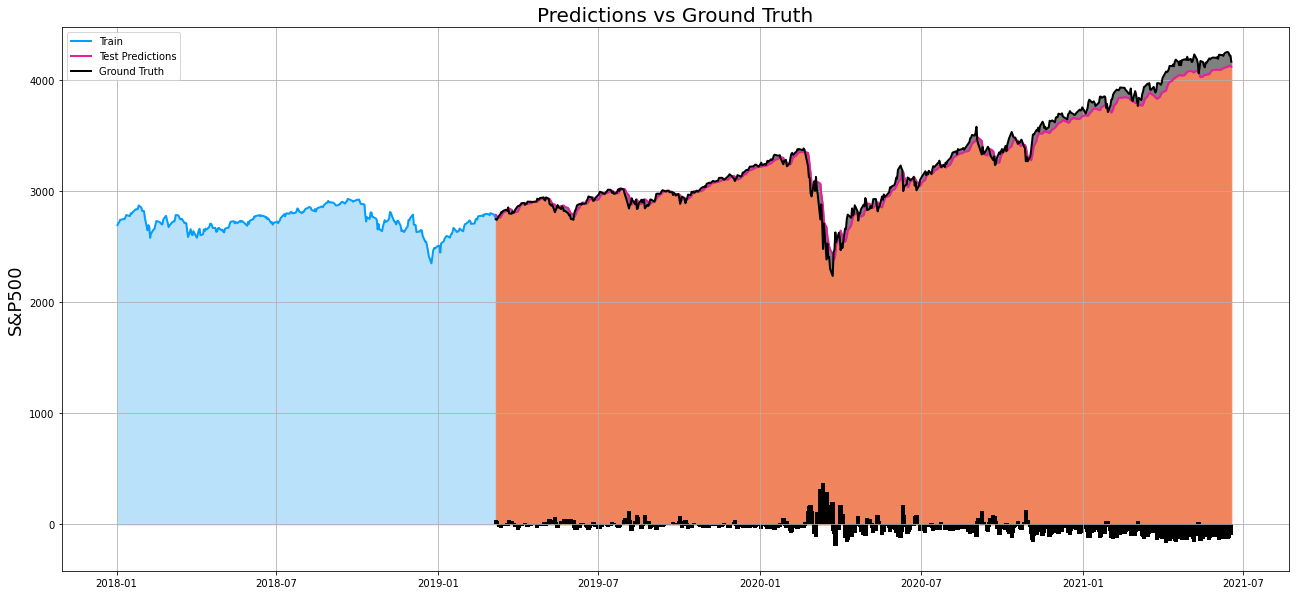

In [51]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = data[:training_data_length + 1]
valid = data[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=2.0)
plt.plot(yv["Predictions"], color="#E91D9E", linewidth=2.0)
plt.plot(yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="grey") 

# Create the bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

In [52]:
# Show the valid and predicted prices
dif = valid['Close'] - valid['Predictions']
valid.insert(2, 'Difference', dif, True)
valid.tail(5)

,Close,Difference,Difference,Predictions
Date,,,,
2021-06-14,4255.149902,-133.966797,133.966797,4121.183105
2021-06-15,4246.589844,-118.450684,118.450684,4128.139160
2021-06-16,4223.700195,-92.181152,92.181152,4131.519043
2021-06-17,4221.859863,-94.723633,94.723633,4127.136230
2021-06-18,4166.450195,-46.080078,46.080078,4120.370117


# Step #6 Predict Next Day's Price

In [55]:
# Get fresh data until today and create a new dataframe with only the price data
price_quote = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
new_df = price_quote.filter(['Close'])

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = mmscaler.transform(new_df[-100:].values)

# Create an empty list and Append past 100 days
X_test = []
X_test.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(new_df['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

plus = '+'; minus = '-'
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if percent > 0 else minus}{percent}%)')

The close price for S&P500 at 2021-06-19 was 4166.45
The predicted close price is 4102.3798828125 (+1.54%)
